# Transfer learning and File-Tunining

- How to classify images of cats and dogs by using transfer learning from a pre-trained network

- Two ways to customer a pretained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simple add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that generically usefull for classifying pictures. However, the final classification part of pretrained model is specific to the original classfication task, and subsequently specific  to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

### Importing

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2025-04-02 20:22:58.256071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# glob.glob(f"{PATH}/cats_and_dogs_extracted/cats_and_dogs_filtered/*")

### Data preprocessing

#### Data Download

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), r"cats_and_dogs_extracted/cats_and_dogs_filtered/")

train_dir = os.path.join(PATH, "train")
validation_dr = os.path.join(PATH, "validation")

if not os.path.exists(train_dir) or not os.path.exists(validation_dr):
    raise FileNotFoundError("Unable to located dataset")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dr,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


The first nine images and labels from the training set:

2025-04-02 20:23:08.360492: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


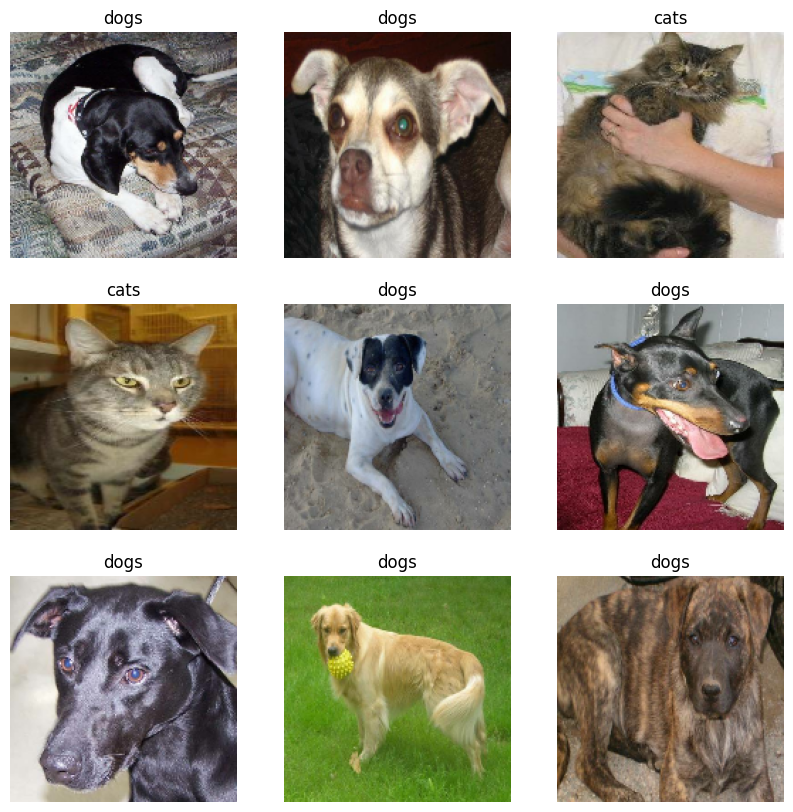

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The original dataset doesn't contain a test set, we'lll create one.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation

When you don't have a large image dataset, it's a good practice to articially introduce sample diversity by apply random, yet realistc, transformations to the training images, such as rotation and horizontal flip

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these alyers to the same image and see the result.

2025-04-02 22:15:04.233214: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


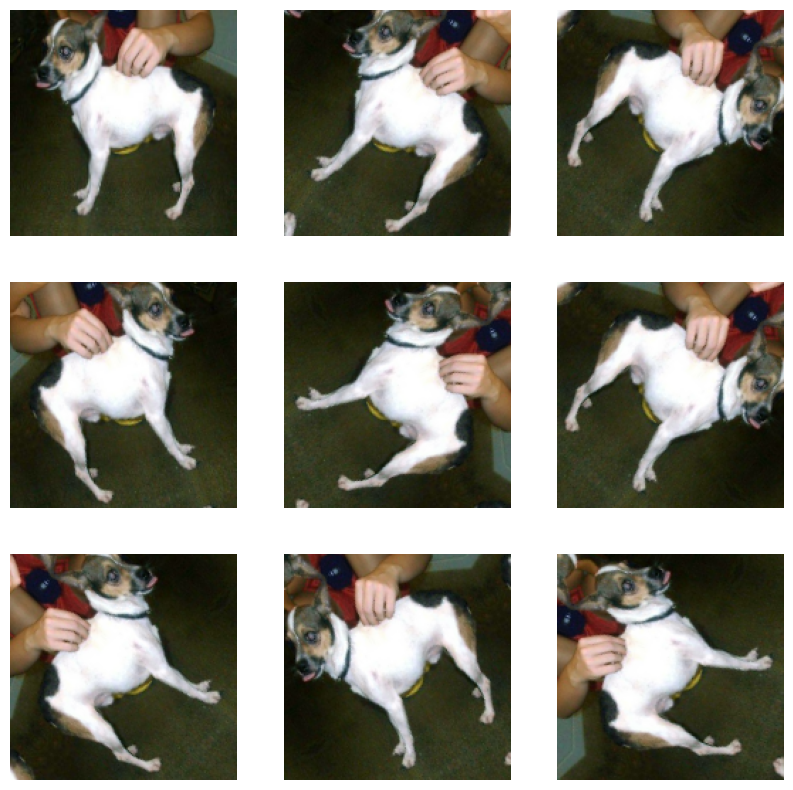

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescale pixel values

Will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, this pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pretrained convnets

Will crate the base model from the **MobileNet V2** model developed at Google. This pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we need to pick which layer of MobileNet V2 we will use for feature extraction. This very last classficitation lyer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument,you load a network that dones't include the classification layers at the top, which is ideal for the feature extraction

In [13]:
# create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch)

2025-04-02 22:58:42.959203: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2025-04-02 22:58:43.029921: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2025-04-02 22:58:43.040408: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2025-04-02 22:58:43.057322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2025-04-02 22:58:43.069019: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.


tf.Tensor(
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [1.0460017e+00 4.4939041e-02 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 8.6597443e-02 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [3.1053836e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [2.3826997e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [5.2055902e+00 1.1225748e-01 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 1.8630028e-03]
   [2.4537723e+00 1.1275444e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]]

  [[1.1858313e+

### Feature extraction

In this step, you will freeze the convolutional base created from 